## 1. Setup

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import spacy
import matplotlib.pyplot as plt
import sacrebleu
import optuna
from collections import Counter
import math

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Load Dataset

In [15]:
dataset = load_dataset("europarl_bilingual", "en-fr")

train_data = dataset['train'].select(range(10000))
val_data = dataset['train'].select(range(10000, 10500))

train-00000-of-00002.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2051014 [00:00<?, ? examples/s]

## 3. Tokenization & Vocabulary

In [16]:
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize(text, spacy_model):
    return [tok.text.lower() for tok in spacy_model.tokenizer(text)]

src_counter, tgt_counter = Counter(), Counter()
for item in train_data:
    src_counter.update(tokenize(item['translation']['en'], spacy_en))
    tgt_counter.update(tokenize(item['translation']['fr'], spacy_fr))

# Define special tokens
PAD_IDX, UNK_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_tokens_src = {"<pad>": PAD_IDX, "<unk>": UNK_IDX}
special_tokens_tgt = {"<pad>": PAD_IDX, "<unk>": UNK_IDX, "<sos>": SOS_IDX, "<eos>": EOS_IDX}


src_vocab = {w: i + len(special_tokens_src) for i, (w, _) in enumerate(src_counter.most_common(30000))}
src_vocab.update(special_tokens_src)
tgt_vocab = {w: i + len(special_tokens_tgt) for i, (w, _) in enumerate(tgt_counter.most_common(30000))}
tgt_vocab.update(special_tokens_tgt)

idx2word_tgt = {v: k for k, v in tgt_vocab.items()}

## 4. Encoding & DataLoader

In [17]:
def encode_src(text, vocab, spacy_model, max_len=60):
    tokens = tokenize(text, spacy_model)[:max_len]
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens]
    ids += [PAD_IDX] * (max_len - len(ids))
    return ids

def encode_tgt(text, vocab, spacy_model, max_len=60):
    tokens = tokenize(text, spacy_model)[:max_len-2]
    ids = [SOS_IDX] + [vocab.get(tok, UNK_IDX) for tok in tokens] + [EOS_IDX]
    ids += [PAD_IDX] * (max_len - len(ids))
    return ids

def collate_fn(batch):
    src = [encode_src(x['translation']['en'], src_vocab, spacy_en) for x in batch]
    tgt = [encode_tgt(x['translation']['fr'], tgt_vocab, spacy_fr) for x in batch]
    return torch.tensor(src).to(device), torch.tensor(tgt).to(device)

train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn, shuffle=True)

## 5. Transformer Model

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerNMT(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_layers=3, dropout=0.1):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(device)

    def forward(self, src, tgt):
        src_padding_mask = (src == PAD_IDX)
        tgt_padding_mask = (tgt == PAD_IDX)
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(1))

        src_emb = self.src_embed(src) * math.sqrt(self.src_embed.embedding_dim)
        tgt_emb = self.tgt_embed(tgt) * math.sqrt(self.tgt_embed.embedding_dim)

        src_emb = self.pos_encoder(src_emb.transpose(0,1)).transpose(0,1)
        tgt_emb = self.pos_encoder(tgt_emb.transpose(0,1)).transpose(0,1)

        out = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask
        )
        return self.fc_out(out)

## 6. Hyperparameter Tuning with Optuna

In [19]:
def objective(trial):
    d_model = trial.suggest_categorical("d_model", [256, 512])
    nhead = trial.suggest_categorical("nhead", [4, 8])
    if d_model % nhead != 0: nhead = 4
    num_layers = trial.suggest_int("num_layers", 2, 4)
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)

    model = TransformerNMT(len(src_vocab), len(tgt_vocab),
                           d_model=d_model, nhead=nhead, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    model.train()
    src, tgt = next(iter(train_loader))

    optimizer.zero_grad()
    output = model(src, tgt[:, :-1])
    loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()

    return loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("Best hyperparameters:", study.best_params)

[I 2025-09-03 14:38:40,062] A new study created in memory with name: no-name-136d9c2a-8870-47c0-bb3a-01d465ba8417
c:\Users\Mayank\Desktop\Labs\.venv\Lib\site-packages\torch\nn\functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
[I 2025-09-03 14:38:42,598] Trial 0 finished with value: 9.759352684020996 and parameters: {'d_model': 256, 'nhead': 4, 'num_layers': 3, 'lr': 0.0001319858560636748}. Best is trial 0 with value: 9.759352684020996.
[I 2025-09-03 14:38:43,045] Trial 1 finished with value: 9.707467079162598 and parameters: {'d_model': 512, 'nhead': 8, 'num_layers': 4, 'lr': 0.00022107427671369938}. Best is trial 1 with value: 9.707467079162598.
[I 2025-09-03 14:38:43,327] Trial 2 finished with value: 9.73355770111084 and parameters: {'d_model': 512, 'nhead': 8, 'num_layers': 2, 'lr': 0.0004209837501327716}. Best is trial 1 with value: 9.707467079162598.
[I 2025-09-03 14:38:43,501] Tri

Best hyperparameters: {'d_model': 256, 'nhead': 8, 'num_layers': 4, 'lr': 0.0003119721614853145}


## 7. Train Final Model

Epoch 1, Loss: 5.9820
Epoch 2, Loss: 4.9924
Epoch 3, Loss: 4.6657
Epoch 4, Loss: 4.4495
Epoch 5, Loss: 4.2775
Epoch 6, Loss: 4.1238
Epoch 7, Loss: 3.9789
Epoch 8, Loss: 3.8452
Epoch 9, Loss: 3.7156
Epoch 10, Loss: 3.5899
Epoch 11, Loss: 3.4712
Epoch 12, Loss: 3.3545
Epoch 13, Loss: 3.2387
Epoch 14, Loss: 3.1305
Epoch 15, Loss: 3.0195


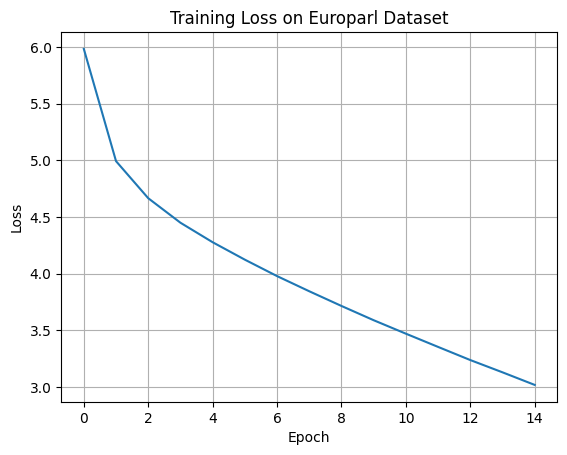

In [22]:
params = study.best_params
if params['d_model'] % params['nhead'] != 0:
    params['nhead'] = 4

model = TransformerNMT(len(src_vocab), len(tgt_vocab), params['d_model'], params['nhead'], params['num_layers']).to(device)
optimizer = optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

losses = []
for epoch in range(15):
    total_loss = 0
    model.train()
    for src, tgt in train_loader:
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.title("Training Loss on Europarl Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## 8. Evaluation

In [23]:
def translate(sentence, max_len=60, beam_size=3):
    model.eval()
    src_tokens = tokenize(sentence, spacy_en)[:max_len]
    src_ids = [src_vocab.get(tok, UNK_IDX) for tok in src_tokens]
    
    unk_count = src_ids.count(UNK_IDX)
    if unk_count > 0:
        print(f"Warning: {unk_count} unknown tokens in input: {src_tokens}")

    src = torch.tensor([src_ids]).to(device)

    beams = [(torch.tensor([[SOS_IDX]]).to(device), 0.0)]  # (sequence, score)
    completed = []

    for _ in range(max_len):
        new_beams = []
        for seq, score in beams:
            if seq[0, -1].item() == EOS_IDX:
                completed.append((seq, score))
                continue

            out = model(src, seq)
            probs = torch.softmax(out[:, -1, :], dim=-1)
            top_probs, top_idx = probs[0].topk(beam_size)

            for prob, idx in zip(top_probs, top_idx):
                new_seq = torch.cat([seq, idx.unsqueeze(0).unsqueeze(0)], dim=1)
                new_score = score - torch.log(prob).item()
                new_beams.append((new_seq, new_score))

        beams = sorted(new_beams, key=lambda x: x[1])[:beam_size]
        if len(completed) >= beam_size:
            break

    # Select best sequence
    all_beams = completed + beams
    best_seq, _ = min(all_beams, key=lambda x: x[1])
    translated_tokens = [idx2word_tgt.get(tok, "<unk>") for tok in best_seq.squeeze(0).tolist()[1:]]
    return " ".join(token for token in translated_tokens if token not in ["<eos>", "<pad>"])

In [28]:
test_idx = 2
en_sentence = val_data[test_idx]['translation']['en']
fr_sentence = val_data[test_idx]['translation']['fr']

print("\n--- Example Translation ---")
print("EN:", en_sentence)
print("FR (True):", fr_sentence)
print("PRED (Model):", translate(en_sentence))
print("---------------------------\n")


--- Example Translation ---
EN: Amendment No 11 replaces 'government or municipal officials' with 'government officials' .
FR (True): L' amendement 11 remplace les termes "administration gouvernementale ou municipale" par "l' ensemble des administrations publiques".
PRED (Model): l' amendement 19 n' a pas été le gouvernement danois de la modification du gouvernement britannique .
---------------------------



In [ ]:
import os
from contextlib import redirect_stdout

# BLEU Score Calculation
refs, preds = [], []
with open(os.devnull, 'w') as f, redirect_stdout(f):
    for item in val_data.select(range(100)):
        refs.append([item['translation']['fr']])
        preds.append(translate(item['translation']['en']))

    bleu = sacrebleu.corpus_bleu(preds, refs)

print(f"Final BLEU Score on Europarl validation set: {bleu.score:.2f}")

Final BLEU Score on Europarl validation set: 32.65
